In [1]:
import numpy as np
import pandas as pd
data_Tg = pd.read_excel(r'copolymer_Tg_data_real.xlsx')
data_Tm = pd.read_excel(r'copolymer_Tm_data_real.xlsx')
data_gpt_Tg = pd.read_excel(r'copolymer_Tg_data_llm.xlsx')
data_gpt_Tm = pd.read_excel(r'copolymer_Tm_data_llm.xlsx')

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings('ignore')
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

def get_copolymer_mfp(smi1,smi2,ratio):
    ratio=0.01*ratio
    mfp1=get_Morgan_fingerprint_frequency(smi1)
    mfp2=get_Morgan_fingerprint_frequency(smi2)
    if mfp1 is not None and mfp2 is not None:
        mfp=[mfp1[i]*ratio+mfp2[i]*(1-ratio) for i in range(len(mfp1))]
    else:
        mfp=None
    return mfp

### 1. Data preprocessing

In [6]:
data_Tg['Compotision1_ratio/%'] = pd.to_numeric(data_Tg['Compotision1_ratio/%'], errors='coerce')
data_Tm['Compotision1_ratio/%'] = pd.to_numeric(data_Tm['Compotision1_ratio/%'], errors='coerce')
data_Tg['morgan_fp_with_freq']=data_Tg.apply(lambda x: get_copolymer_mfp(x['Component 1 smiles'],x['Component 2 smiles'],x['Compotision1_ratio/%']),axis=1)
data_Tm['morgan_fp_with_freq']=data_Tm.apply(lambda x: get_copolymer_mfp(x['Component 1 smiles'],x['Component 2 smiles'],x['Compotision1_ratio/%']),axis=1)
data_Tg['Tg'] = data_Tg['Tg'].astype(float)
data_Tm['Tm']=data_Tm['Tm'].astype(float)
data_Tg= data_Tg[data_Tg['Tg'].notna()]
data_Tm= data_Tm[data_Tm['Tm'].notna()]
data_Tg=data_Tg.dropna(subset=['morgan_fp_with_freq'])
data_Tm=data_Tm.dropna(subset=['morgan_fp_with_freq'])
data_Tg=data_Tg.reset_index(drop=True)
data_Tm=data_Tm.reset_index(drop=True)

In [7]:
data_gpt_Tg['Composition1_ratio'] = pd.to_numeric(data_gpt_Tg['Composition1_ratio'], errors='coerce')
data_gpt_Tm['Composition1_ratio'] = pd.to_numeric(data_gpt_Tm['Composition1_ratio'], errors='coerce')
data_gpt_Tg['morgan_fp_with_freq']=data_gpt_Tg.apply(lambda x: get_copolymer_mfp(x['Component_1_smiles'],x['Component_2_smiles'],x['Composition1_ratio']),axis=1)
data_gpt_Tm['morgan_fp_with_freq']=data_gpt_Tm.apply(lambda x: get_copolymer_mfp(x['Component_1_smiles'],x['Component_2_smiles'],x['Composition1_ratio']),axis=1)
data_gpt_Tg= data_gpt_Tg[data_gpt_Tg['Glass transition temperature'].notna()]
data_gpt_Tm= data_gpt_Tm[data_gpt_Tm['Melting temperature'].notna()]
data_gpt_Tg=data_gpt_Tg.dropna(subset=['morgan_fp_with_freq'])
data_gpt_Tm=data_gpt_Tm.dropna(subset=['morgan_fp_with_freq'])
data_gpt_Tg=data_gpt_Tg.reset_index(drop=True)
data_gpt_Tm=data_gpt_Tm.reset_index(drop=True)
data_gpt_Tg = data_gpt_Tg[~data_gpt_Tg['morgan_fp_with_freq'].apply(lambda x: pd.isna(x).all() or (isinstance(x, list) and all(str(i).lower() == 'nan' for i in x)))]
data_gpt_Tm = data_gpt_Tm[~data_gpt_Tm['morgan_fp_with_freq'].apply(lambda x: pd.isna(x).all() or (isinstance(x, list) and all(str(i).lower() == 'nan' for i in x)))]

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt

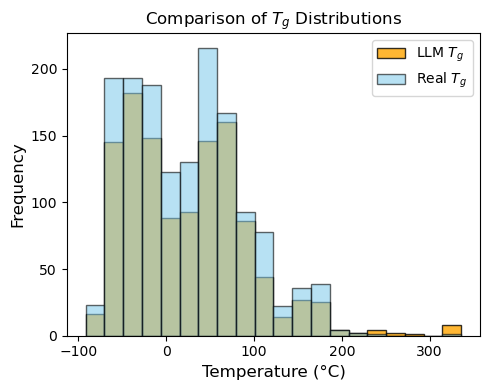

In [12]:
xmin = min(data_gpt_Tg['Glass transition temperature'].min(), data_Tg['Tg'].min())
xmax = max(data_gpt_Tg['Glass transition temperature'].max(), data_Tg['Tg'].max())
bins = np.linspace(xmin, xmax, 21)
plt.figure(figsize=(5, 4))
plt.hist(data_gpt_Tg['Glass transition temperature'], bins=bins, color='orange', edgecolor='black', alpha=0.8, label='LLM $T_{g}$')
plt.hist(data_Tg['Tg'], bins=bins, color='skyblue', edgecolor='black', alpha=0.6, label='Real $T_{g}$')
plt.title('Comparison of $T_{g}$ Distributions')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('Tg_distribution.jpg',dpi=300)

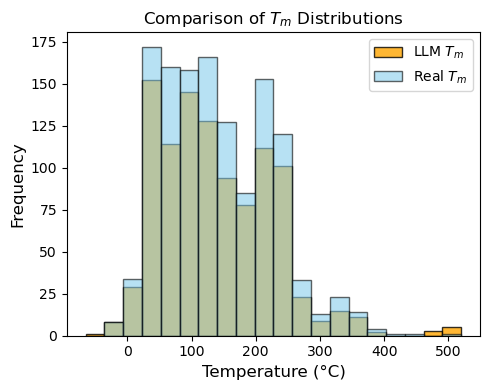

In [13]:
xmin = min(data_gpt_Tm['Melting temperature'].min(), data_Tm['Tm'].min())
xmax = max(data_gpt_Tm['Melting temperature'].max(), data_Tm['Tm'].max())
bins = np.linspace(xmin, xmax, 21)
plt.figure(figsize=(5, 4))
plt.hist(data_gpt_Tm['Melting temperature'], bins=bins, color='orange', edgecolor='black', alpha=0.8, label='LLM $T_{m}$')
plt.hist(data_Tm['Tm'], bins=bins, color='skyblue', edgecolor='black', alpha=0.6, label='Real $T_{m}$')
plt.title('Comparison of $T_{m}$ Distributions')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('Tm_distribution.jpg',dpi=300)

In [14]:
(len(data_gpt_Tg),len(data_gpt_Tm))

(1195, 1030)

### 2. QSPR for $T_g$

#### 2.1 Real $T_g$ prediction performance

In [17]:
random_seed = 85
np.random.seed(random_seed)
extra_test_size = 0.05
extra_test_ids = np.random.choice(np.intersect1d(data_Tg['ID'].unique(), data_gpt_Tg['ID'].unique()), 
                                size=int(len(np.intersect1d(data_Tg['ID'].unique(), data_gpt_Tg['ID'].unique())) * extra_test_size), 
                                replace=False)
extra_test_ids

array([206, 239,  39, 169, 247,  57, 377, 110,  66,  46, 137, 205],
      dtype=int64)

In [18]:
extra_test_set_Tg_real = data_Tg[data_Tg['ID'].isin(extra_test_ids)]
remaining_data_Tg_real = data_Tg[~data_Tg['ID'].isin(extra_test_ids)]
X_Tg_real = remaining_data_Tg_real['morgan_fp_with_freq'].tolist()
y_Tg_real = remaining_data_Tg_real['Tg'].tolist()

X_extra_test_Tg_real = extra_test_set_Tg_real['morgan_fp_with_freq'].tolist()
y_extra_test_Tg_real = extra_test_set_Tg_real['Tg'].tolist()

# 将剩余数据按照 train:valid:test = 8:1:1 划分
X_train_Tg_real, X_temp_Tg_real, y_train_Tg_real, y_temp_Tg_real = train_test_split(X_Tg_real, y_Tg_real, test_size=0.2, random_state=random_seed)
X_valid_Tg_real, X_test_Tg_real, y_valid_Tg_real, y_test_Tg_real = train_test_split(X_temp_Tg_real, y_temp_Tg_real, test_size=0.5, random_state=random_seed)

model = RandomForestRegressor(n_estimators=100,random_state=random_seed)
model.fit(X_train_Tg_real, y_train_Tg_real)

y_train_pred_Tg_real = model.predict(X_train_Tg_real)
y_valid_pred_Tg_real = model.predict(X_valid_Tg_real)
y_test_pred_Tg_real = model.predict(X_test_Tg_real)
y_extra_test_pred_Tg_real = model.predict(X_extra_test_Tg_real)

mse_train_Tg_real = mean_squared_error(y_train_Tg_real, y_train_pred_Tg_real)
mse_valid_Tg_real = mean_squared_error(y_valid_Tg_real, y_valid_pred_Tg_real)
mse_test_Tg_real = mean_squared_error(y_test_Tg_real, y_test_pred_Tg_real)
mse_extra_test_Tg_real = mean_squared_error(y_extra_test_Tg_real, y_extra_test_pred_Tg_real)

mae_train_Tg_real=mean_absolute_error(y_train_Tg_real, y_train_pred_Tg_real)
mae_valid_Tg_real=mean_absolute_error(y_valid_Tg_real, y_valid_pred_Tg_real)
mae_test_Tg_real=mean_absolute_error(y_test_Tg_real, y_test_pred_Tg_real)
mae_extra_test_Tg_real=mean_absolute_error(y_extra_test_Tg_real, y_extra_test_pred_Tg_real)

r2_train_Tg_real = r2_score(y_train_Tg_real, y_train_pred_Tg_real)
r2_valid_Tg_real = r2_score(y_valid_Tg_real, y_valid_pred_Tg_real)
r2_test_Tg_real = r2_score(y_test_Tg_real, y_test_pred_Tg_real)
r2_extra_test_Tg_real = r2_score(y_extra_test_Tg_real, y_extra_test_pred_Tg_real)

print(f"Train MSE: {mse_train_Tg_real}, MAE:{mae_train_Tg_real},R2: {r2_train_Tg_real}")
print(f"Validation MSE: {mse_valid_Tg_real}, MAE:{mae_valid_Tg_real},R2: {r2_valid_Tg_real}")
print(f"Test MSE: {mse_test_Tg_real}, MAE:{mae_test_Tg_real},R2: {r2_test_Tg_real}")
print(f"Extra Test MSE: {mse_extra_test_Tg_real}, MAE:{mae_extra_test_Tg_real},R2: {r2_extra_test_Tg_real}")

Train MSE: 85.4244248665295, MAE:4.543456614654989,R2: 0.9790035439077591
Validation MSE: 269.27274537163265, MAE:10.107097548992813,R2: 0.9355183137154639
Test MSE: 211.8711700485569, MAE:9.25524049586241,R2: 0.9466558497996218
Extra Test MSE: 687.731608379989, MAE:19.07578481697627,R2: 0.8243019320863305


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_r2 = -np.inf
best_params = None
best_results = {}


param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}


from itertools import product
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'],
                                   param_grid['min_samples_split'], param_grid['min_samples_leaf']))


X = np.array(X_Tg_real)
y = np.array(y_Tg_real)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for n_est, max_d, min_split, min_leaf in param_combinations:
    r2_valid_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)
        
        model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        
        r2_valid = r2_score(y_valid, valid_preds)
        r2_valid_scores.append(r2_valid)
    
    mean_r2_valid = np.mean(r2_valid_scores)
    print(f"Params: n_estimators={n_est}, max_depth={max_d}, min_samples_split={min_split}, min_samples_leaf={min_leaf} => mean R2: {mean_r2_valid:.4f}")
    
    if mean_r2_valid > best_r2:
        best_r2 = mean_r2_valid
        best_params = (n_est, max_d, min_split, min_leaf)
        best_results = {
            'mean_r2_valid': mean_r2_valid,
            'params': {
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf
            }
        }

print("\n✅ Best Parameters and R2 Score:")
print(best_results)


In [19]:
from sklearn.model_selection import cross_val_score, KFold
import joblib
import os

if not os.path.exists('Real_Tg_RF_10fold_saved_models'):
    os.makedirs('Real_Tg_RF_10fold_saved_models')

X = np.array(X_Tg_real)
y = np.array(y_Tg_real)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]


#for train_idx, test_idx in kf.split(X):
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42)
    model.fit(X_train, y_train)
    
    model_filename = f'Real_Tg_RF_10fold_saved_models/RF_{i+1:03d}.pkl'
    joblib.dump(model, model_filename)
    print(f'Model saved as {model_filename}')
    
    
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tg_real)
    
    # 计算并存储MSE
    mse_train_Tg_real = mean_squared_error(y_train, train_preds)
    mse_valid_Tg_real = mean_squared_error(y_valid, valid_preds)
    mse_test_Tg_real = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tg_real=mean_squared_error(y_extra_test_Tg_real, extra_test_preds)

    mae_train_Tg_real=mean_absolute_error(y_train, train_preds)
    mae_valid_Tg_real=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tg_real=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tg_real=mean_absolute_error(y_extra_test_Tg_real, extra_test_preds)

    r2_train_Tg_real = r2_score(y_train, train_preds)
    r2_valid_Tg_real = r2_score(y_valid, valid_preds)
    r2_test_Tg_real = r2_score(y_test, test_preds)
    r2_extra_test_Tg_real = r2_score(y_extra_test_Tg_real, extra_test_preds)

    # print('------------------------')
    # print(f"Train MSE: {mse_train_Tg_real}, MAE:{mae_train_Tg_real},R2: {r2_train_Tg_real}")
    # print(f"Validation MSE: {mse_valid_Tg_real}, MAE:{mae_valid_Tg_real},R2: {r2_valid_Tg_real}")
    # print(f"Test MSE: {mse_test_Tg_real}, MAE:{mae_test_Tg_real},R2: {r2_test_Tg_real}")
    # print(f"Extra Test MSE: {mse_extra_test_Tg_real}, MAE:{mae_extra_test_Tg_real},R2: {r2_extra_test_Tg_real}")

    mse_train_scores.append(mse_train_Tg_real)
    mse_valid_scores.append(mse_valid_Tg_real)
    mse_test_scores.append(mse_test_Tg_real)
    mse_extra_test_scores.append(mse_extra_test_Tg_real)

    mae_train_scores.append(mae_train_Tg_real)
    mae_valid_scores.append(mae_valid_Tg_real)
    mae_test_scores.append(mae_test_Tg_real)
    mae_extra_test_scores.append(mae_extra_test_Tg_real)

    r2_train_scores.append(r2_train_Tg_real)
    r2_valid_scores.append(r2_valid_Tg_real)
    r2_test_scores.append(r2_test_Tg_real)
    r2_extra_test_scores.append(r2_extra_test_Tg_real)
    

Model saved as Real_Tg_RF_10fold_saved_models/RF_001.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_002.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_003.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_004.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_005.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_006.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_007.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_008.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_009.pkl
Model saved as Real_Tg_RF_10fold_saved_models/RF_010.pkl


In [20]:
print(f"Mean Train MSE: {np.mean(mse_train_scores):.4f} ± {np.std(mse_train_scores):.4f}, MAE: {np.mean(mae_train_scores):.4f} ± {np.std(mae_train_scores):.4f}, R2: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Mean Validation MSE: {np.mean(mse_valid_scores):.4f} ± {np.std(mse_valid_scores):.4f}, MAE: {np.mean(mae_valid_scores):.4f} ± {np.std(mae_valid_scores):.4f}, R2: {np.mean(r2_valid_scores):.4f} ± {np.std(r2_valid_scores):.4f}")
print(f"Mean Test MSE: {np.mean(mse_test_scores):.4f} ± {np.std(mse_test_scores):.4f}, MAE: {np.mean(mae_test_scores):.4f} ± {np.std(mae_test_scores):.4f}, R2: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Mean Extra Test MSE: {np.mean(mse_extra_test_scores):.4f} ± {np.std(mse_extra_test_scores):.4f}, MAE: {np.mean(mae_extra_test_scores):.4f} ± {np.std(mae_extra_test_scores):.4f}, R2: {np.mean(r2_extra_test_scores):.4f} ± {np.std(r2_extra_test_scores):.4f}")

Mean Train MSE: 103.7959 ± 12.5406, MAE: 5.3988 ± 0.2148, R2: 0.9750 ± 0.0027
Mean Validation MSE: 442.7705 ± 128.4697, MAE: 11.1102 ± 1.1604, R2: 0.8740 ± 0.0284
Mean Test MSE: 442.3789 ± 216.9411, MAE: 11.4559 ± 2.2103, R2: 0.8922 ± 0.0487
Mean Extra Test MSE: 604.5811 ± 80.9437, MAE: 17.7259 ± 1.0183, R2: 0.8455 ± 0.0207


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

X = np.array(X_Tg_real)
y = np.array(y_Tg_real)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储评估结果
mse_train_scores = []
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores = []

mae_train_scores = []
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores = []

r2_train_scores = []
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores = []

# 可视化用列表
test_true_list = []
test_pred_list = []

for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    # 数据划分
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

    # 模型训练
    model = RandomForestRegressor(
        n_estimators=150,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train, y_train)

    # 预测
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds = model.predict(X_extra_test_Tg_real)

    # 评估指标
    mse_train_scores.append(mean_squared_error(y_train, train_preds))
    mse_valid_scores.append(mean_squared_error(y_valid, valid_preds))
    mse_test_scores.append(mean_squared_error(y_test, test_preds))
    mse_extra_test_scores.append(mean_squared_error(y_extra_test_Tg_real, extra_test_preds))

    mae_train = mean_absolute_error(y_train, train_preds)
    mae_valid = mean_absolute_error(y_valid, valid_preds)
    mae_test = mean_absolute_error(y_test, test_preds)
    mae_extra = mean_absolute_error(y_extra_test_Tg_real, extra_test_preds)

    mae_train_scores.append(mae_train)
    mae_valid_scores.append(mae_valid)
    mae_test_scores.append(mae_test)
    mae_extra_test_scores.append(mae_extra)

    r2_train = r2_score(y_train, train_preds)
    r2_valid = r2_score(y_valid, valid_preds)
    r2_test = r2_score(y_test, test_preds)
    r2_extra = r2_score(y_extra_test_Tg_real, extra_test_preds)

    r2_train_scores.append(r2_train)
    r2_valid_scores.append(r2_valid)
    r2_test_scores.append(r2_test)
    r2_extra_test_scores.append(r2_extra)

    # 存储真实值与预测值用于绘图
    test_true_list.append(y_test)
    test_pred_list.append(test_preds)



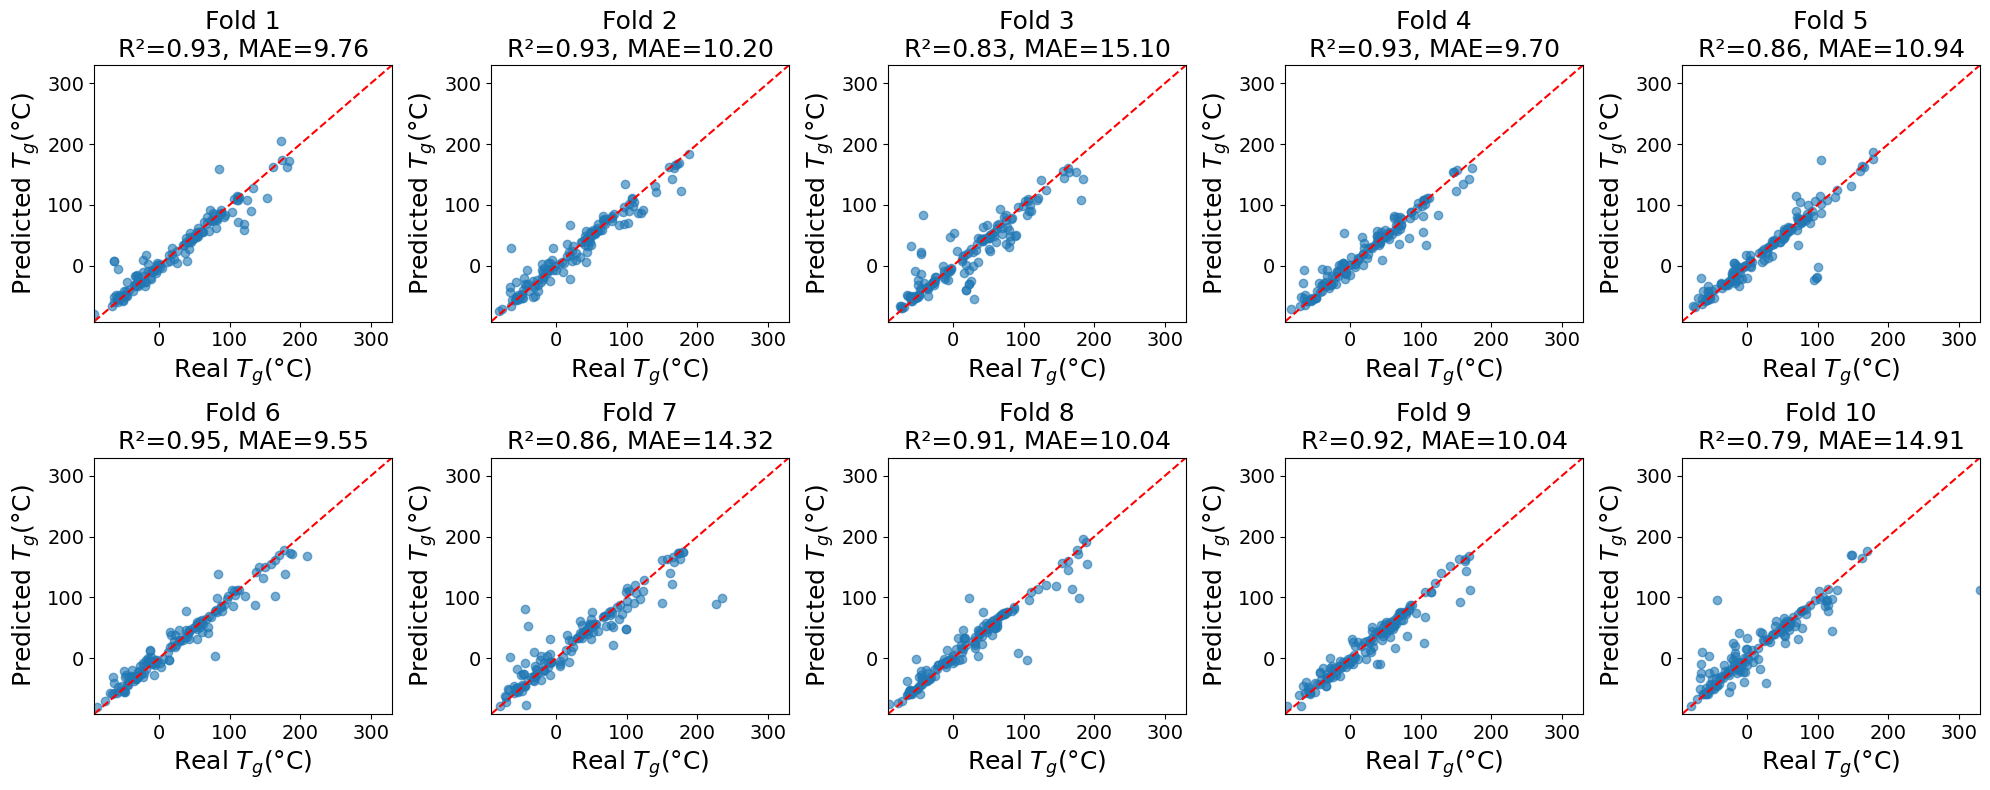

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 获取全局范围
all_true = np.concatenate(test_true_list)
all_pred = np.concatenate(test_pred_list)
min_val = min(all_true.min(), all_pred.min())
max_val = max(all_true.max(), all_pred.max())

for i in range(10):
    ax = axes[i]
    ax.scatter(test_true_list[i], test_pred_list[i], alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val],
            color='red', linestyle='--')
    
    r2 = r2_test_scores[i]
    mae = mae_test_scores[i]
    ax.set_title(f'Fold {i+1}\nR²={r2:.2f}, MAE={mae:.2f}', fontsize=18)
    ax.set_xlabel('Real $T_{g}$(°C)', fontsize=18)
    ax.set_ylabel('Predicted $T_{g}$(°C)', fontsize=18)
    
    # 设置统一坐标范围和刻度字体
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.suptitle('Real vs Predicted $T_{g}$ for Each Fold (Test Set)', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('real_Tg_data_10cv.jpg', dpi=400)


#### 2.2 LLM $T_g$ prediction performance

In [23]:
#extra_test_set = data_gpt_Tg[data_gpt_Tg['ID'].isin(extra_test_ids)]
extra_test_set_Tg_gpt = data_Tg[data_Tg['ID'].isin(extra_test_ids)]
remaining_data_Tg_gpt = data_gpt_Tg[~data_gpt_Tg['ID'].isin(extra_test_ids)]
X_Tg_gpt = remaining_data_Tg_gpt['morgan_fp_with_freq'].tolist()
y_Tg_gpt = remaining_data_Tg_gpt['Glass transition temperature'].tolist()

# 将输入转换为合适的格式 (假设每个元素为list型的指纹)
X_extra_test_Tg_gpt = extra_test_set_Tg_gpt['morgan_fp_with_freq'].tolist()
y_extra_test_Tg_gpt = extra_test_set_Tg_gpt['Tg'].tolist()

# 将剩余数据按照 train:valid:test = 8:1:1 划分
X_train_Tg_gpt, X_temp_Tg_gpt, y_train_Tg_gpt, y_temp_Tg_gpt = train_test_split(X_Tg_gpt, y_Tg_gpt, test_size=0.2, random_state=random_seed)
X_valid_Tg_gpt, X_test_Tg_gpt, y_valid_Tg_gpt, y_test_Tg_gpt = train_test_split(X_temp_Tg_gpt, y_temp_Tg_gpt, test_size=0.5, random_state=random_seed)

model = RandomForestRegressor(n_estimators=100,random_state=random_seed)
model.fit(X_train_Tg_gpt, y_train_Tg_gpt)

# 评估模型
y_train_pred_Tg_gpt = model.predict(X_train_Tg_gpt)
y_valid_pred_Tg_gpt = model.predict(X_valid_Tg_gpt)
y_test_pred_Tg_gpt = model.predict(X_test_Tg_gpt)
y_extra_test_pred_Tg_gpt = model.predict(X_extra_test_Tg_gpt)

mse_train_Tg_gpt = mean_squared_error(y_train_Tg_gpt, y_train_pred_Tg_gpt)
mse_valid_Tg_gpt = mean_squared_error(y_valid_Tg_gpt, y_valid_pred_Tg_gpt)
mse_test_Tg_gpt = mean_squared_error(y_test_Tg_gpt, y_test_pred_Tg_gpt)
mse_extra_test_Tg_gpt = mean_squared_error(y_extra_test_Tg_gpt, y_extra_test_pred_Tg_gpt)

mae_train_Tg_gpt=mean_absolute_error(y_train_Tg_gpt, y_train_pred_Tg_gpt)
mae_valid_Tg_gpt=mean_absolute_error(y_valid_Tg_gpt, y_valid_pred_Tg_gpt)
mae_test_Tg_gpt=mean_absolute_error(y_test_Tg_gpt, y_test_pred_Tg_gpt)
mae_extra_test_Tg_gpt=mean_absolute_error(y_extra_test_Tg_gpt, y_extra_test_pred_Tg_gpt)

r2_train_Tg_gpt = r2_score(y_train_Tg_gpt, y_train_pred_Tg_gpt)
r2_valid_Tg_gpt = r2_score(y_valid_Tg_gpt, y_valid_pred_Tg_gpt)
r2_test_Tg_gpt = r2_score(y_test_Tg_gpt, y_test_pred_Tg_gpt)
r2_extra_test_Tg_gpt = r2_score(y_extra_test_Tg_gpt, y_extra_test_pred_Tg_gpt)

print(f"Train MSE: {mse_train_Tg_gpt}, MAE:{mae_train_Tg_gpt},R2: {r2_train_Tg_gpt}")
print(f"Validation MSE: {mse_valid_Tg_gpt}, MAE:{mae_valid_Tg_gpt},R2: {r2_valid_Tg_gpt}")
print(f"Test MSE: {mse_test_Tg_gpt}, MAE:{mae_test_Tg_gpt},R2: {r2_test_Tg_gpt}")
print(f"Extra Test MSE: {mse_extra_test_Tg_gpt}, MAE:{mae_extra_test_Tg_gpt},R2: {r2_extra_test_Tg_gpt}")


Train MSE: 169.50451136924235, MAE:5.908294295128484,R2: 0.9662022703640929
Validation MSE: 684.9073045973315, MAE:15.316370590255598,R2: 0.8046076579844018
Test MSE: 236.1774363789497, MAE:10.518815191448683,R2: 0.9512301973213142
Extra Test MSE: 572.212195155266, MAE:18.028895595332934,R2: 0.853814226508736


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_r2 = -np.inf
best_params = None
best_results = {}


param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# 枚举所有参数组合
from itertools import product
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'],
                                   param_grid['min_samples_split'], param_grid['min_samples_leaf']))

X = np.array(X_Tg_gpt)
y = np.array(y_Tg_gpt)

kf = KFold(n_splits=10, shuffle=True, random_state=46)

for n_est, max_d, min_split, min_leaf in param_combinations:
    r2_valid_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)
        
        model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        
        r2_valid = r2_score(y_valid, valid_preds)
        r2_valid_scores.append(r2_valid)
    
    mean_r2_valid = np.mean(r2_valid_scores)
    print(f"Params: n_estimators={n_est}, max_depth={max_d}, min_samples_split={min_split}, min_samples_leaf={min_leaf} => mean R2: {mean_r2_valid:.4f}")
    
    if mean_r2_valid > best_r2:
        best_r2 = mean_r2_valid
        best_params = (n_est, max_d, min_split, min_leaf)
        best_results = {
            'mean_r2_valid': mean_r2_valid,
            'params': {
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf
            }
        }

print("\n✅ Best Parameters and R2 Score:")
print(best_results)


In [24]:
from sklearn.model_selection import cross_val_score, KFold

X = np.array(X_Tg_gpt)
y = np.array(y_Tg_gpt)

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=46)

# 存储每一折的评估结果
mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]

for train_idx, test_idx in kf.split(X):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    # 在训练集上进行train:valid拆分
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    #model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)
    
    # 在验证集和测试集上评估模型
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tg_gpt)
    
    # 计算并存储MSE
    mse_train_Tg_gpt = mean_squared_error(y_train, train_preds)
    mse_valid_Tg_gpt = mean_squared_error(y_valid, valid_preds)
    mse_test_Tg_gpt = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tg_gpt=mean_squared_error(y_extra_test_Tg_gpt, extra_test_preds)

    mae_train_Tg_gpt=mean_absolute_error(y_train, train_preds)
    mae_valid_Tg_gpt=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tg_gpt=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tg_gpt=mean_absolute_error(y_extra_test_Tg_gpt, extra_test_preds)

    r2_train_Tg_gpt = r2_score(y_train, train_preds)
    r2_valid_Tg_gpt = r2_score(y_valid, valid_preds)
    r2_test_Tg_gpt = r2_score(y_test, test_preds)
    r2_extra_test_Tg_gpt = r2_score(y_extra_test_Tg_gpt, extra_test_preds)

    # print('------------------------')
    # print(f"Train MSE: {mse_train_Tg_gpt}, MAE:{mae_train_Tg_gpt},R2: {r2_train_Tg_gpt}")
    # print(f"Validation MSE: {mse_valid_Tg_gpt}, MAE:{mae_valid_Tg_gpt},R2: {r2_valid_Tg_gpt}")
    # print(f"Test MSE: {mse_test_Tg_gpt}, MAE:{mae_test_Tg_gpt},R2: {r2_test_Tg_gpt}")
    # print(f"Extra Test MSE: {mse_extra_test_Tg_gpt}, MAE:{mae_extra_test_Tg_gpt},R2: {r2_extra_test_Tg_gpt}")

    mse_train_scores.append(mse_train_Tg_gpt)
    mse_valid_scores.append(mse_valid_Tg_gpt)
    mse_test_scores.append(mse_test_Tg_gpt)
    mse_extra_test_scores.append(mse_extra_test_Tg_gpt)

    mae_train_scores.append(mae_train_Tg_gpt)
    mae_valid_scores.append(mae_valid_Tg_gpt)
    mae_test_scores.append(mae_test_Tg_gpt)
    mae_extra_test_scores.append(mae_extra_test_Tg_gpt)

    r2_train_scores.append(r2_train_Tg_gpt)
    r2_valid_scores.append(r2_valid_Tg_gpt)
    r2_test_scores.append(r2_test_Tg_gpt)
    r2_extra_test_scores.append(r2_extra_test_Tg_gpt)

In [25]:
print(f"Mean Train MSE: {np.mean(mse_train_scores):.4f} ± {np.std(mse_train_scores):.4f}, MAE: {np.mean(mae_train_scores):.4f} ± {np.std(mae_train_scores):.4f}, R2: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Mean Validation MSE: {np.mean(mse_valid_scores):.4f} ± {np.std(mse_valid_scores):.4f}, MAE: {np.mean(mae_valid_scores):.4f} ± {np.std(mae_valid_scores):.4f}, R2: {np.mean(r2_valid_scores):.4f} ± {np.std(r2_valid_scores):.4f}")
print(f"Mean Test MSE: {np.mean(mse_test_scores):.4f} ± {np.std(mse_test_scores):.4f}, MAE: {np.mean(mae_test_scores):.4f} ± {np.std(mae_test_scores):.4f}, R2: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Mean Extra Test MSE: {np.mean(mse_extra_test_scores):.4f} ± {np.std(mse_extra_test_scores):.4f}, MAE: {np.mean(mae_extra_test_scores):.4f} ± {np.std(mae_extra_test_scores):.4f}, R2: {np.mean(r2_extra_test_scores):.4f} ± {np.std(r2_extra_test_scores):.4f}")

Mean Train MSE: 271.0092 ± 23.7894, MAE: 7.3408 ± 0.2488, R2: 0.9435 ± 0.0056
Mean Validation MSE: 576.2715 ± 451.5648, MAE: 12.8850 ± 2.6048, R2: 0.8761 ± 0.1146
Mean Test MSE: 1006.4760 ± 361.0801, MAE: 15.2609 ± 1.7055, R2: 0.7942 ± 0.0625
Mean Extra Test MSE: 731.7834 ± 153.2944, MAE: 19.3688 ± 1.4155, R2: 0.8130 ± 0.0392


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

X = np.array(X_Tg_gpt)
y = np.array(y_Tg_gpt)

kf = KFold(n_splits=10, shuffle=True, random_state=46)

# 存储评估结果
mse_train_scores = []
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores = []

mae_train_scores = []
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores = []

r2_train_scores = []
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores = []

# 可视化用列表
test_true_list = []
test_pred_list = []

for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    # 数据划分
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

    # 模型训练
    #model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)

    # 预测
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds = model.predict(X_extra_test_Tg_real)

    # 评估指标
    mse_train_scores.append(mean_squared_error(y_train, train_preds))
    mse_valid_scores.append(mean_squared_error(y_valid, valid_preds))
    mse_test_scores.append(mean_squared_error(y_test, test_preds))
    mse_extra_test_scores.append(mean_squared_error(y_extra_test_Tg_real, extra_test_preds))

    mae_train = mean_absolute_error(y_train, train_preds)
    mae_valid = mean_absolute_error(y_valid, valid_preds)
    mae_test = mean_absolute_error(y_test, test_preds)
    mae_extra = mean_absolute_error(y_extra_test_Tg_real, extra_test_preds)

    mae_train_scores.append(mae_train)
    mae_valid_scores.append(mae_valid)
    mae_test_scores.append(mae_test)
    mae_extra_test_scores.append(mae_extra)

    r2_train = r2_score(y_train, train_preds)
    r2_valid = r2_score(y_valid, valid_preds)
    r2_test = r2_score(y_test, test_preds)
    r2_extra = r2_score(y_extra_test_Tg_real, extra_test_preds)

    r2_train_scores.append(r2_train)
    r2_valid_scores.append(r2_valid)
    r2_test_scores.append(r2_test)
    r2_extra_test_scores.append(r2_extra)

    # 存储真实值与预测值用于绘图
    test_true_list.append(y_test)
    test_pred_list.append(test_preds)

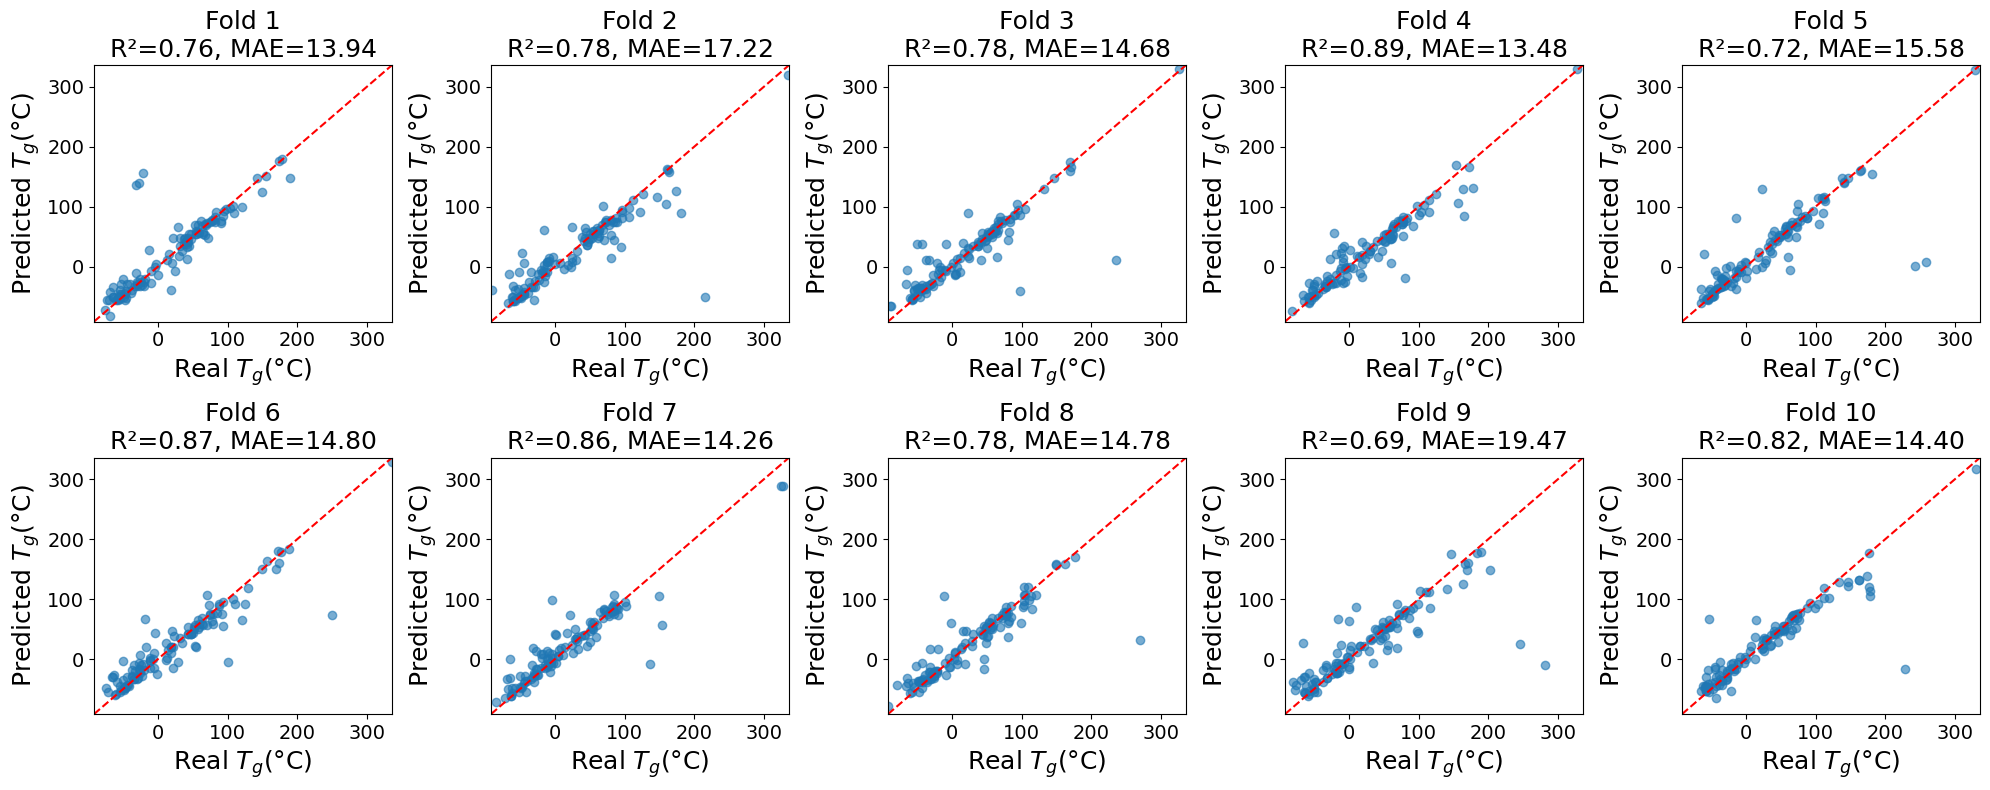

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 获取全局范围
all_true = np.concatenate(test_true_list)
all_pred = np.concatenate(test_pred_list)
min_val = min(all_true.min(), all_pred.min())
max_val = max(all_true.max(), all_pred.max())

for i in range(10):
    ax = axes[i]
    ax.scatter(test_true_list[i], test_pred_list[i], alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val],
            color='red', linestyle='--')
    
    r2 = r2_test_scores[i]
    mae = mae_test_scores[i]
    ax.set_title(f'Fold {i+1}\nR²={r2:.2f}, MAE={mae:.2f}', fontsize=18)
    ax.set_xlabel('Real $T_{g}$(°C)', fontsize=18)
    ax.set_ylabel('Predicted $T_{g}$(°C)', fontsize=18)
    
    # 设置统一坐标范围和刻度字体
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.suptitle('Real vs Predicted $T_{g}$ for Each Fold (Test Set)', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('llm_Tg_data_10cv.jpg', dpi=400)


### 3. QSPR $T_m$ Prediction

#### 3.1 Real Tm Prediction performance

In [28]:
random_seed = 28
np.random.seed(random_seed)
extra_test_size = 0.05
extra_test_ids = np.random.choice(np.intersect1d(data_Tm['ID'].unique(), data_gpt_Tm['ID'].unique()), 
                                size=int(len(np.intersect1d(data_Tm['ID'].unique(), data_gpt_Tm['ID'].unique())) * extra_test_size), 
                                replace=False)
extra_test_ids

array([ 63, 187, 295,  17, 339,  99,  84, 239, 279,  87, 206,  95],
      dtype=int64)

In [29]:
extra_test_set_Tm_real = data_Tm[data_Tm['ID'].isin(extra_test_ids)]
remaining_data_Tm_real = data_Tm[~data_Tm['ID'].isin(extra_test_ids)]

# 提取输入和输出 (针对 Tm 列)
X_Tm_real = remaining_data_Tm_real['morgan_fp_with_freq'].tolist()
y_Tm_real = remaining_data_Tm_real['Tm'].tolist()

# 将输入转换为合适的格式 (假设每个元素为list型的指纹)
X_extra_test_Tm_real = extra_test_set_Tm_real['morgan_fp_with_freq'].tolist()
y_extra_test_Tm_real = extra_test_set_Tm_real['Tm'].tolist()

# 将剩余数据按照 train:valid:test = 8:1:1 划分
X_train_Tm_real, X_temp_Tm_real, y_train_Tm_real, y_temp_Tm_real = train_test_split(X_Tm_real, y_Tm_real, test_size=0.2, random_state=random_seed)
X_valid_Tm_real, X_test_Tm_real, y_valid_Tm_real, y_test_Tm_real = train_test_split(X_temp_Tm_real, y_temp_Tm_real, test_size=0.5, random_state=random_seed)

# 构建随机森林模型
model = RandomForestRegressor(random_state=random_seed)
model.fit(X_train_Tm_real, y_train_Tm_real)

# 评估模型
y_train_pred_Tm_real = model.predict(X_train_Tm_real)
y_valid_pred_Tm_real = model.predict(X_valid_Tm_real)
y_test_pred_Tm_real = model.predict(X_test_Tm_real)
y_extra_test_pred_Tm_real = model.predict(X_extra_test_Tm_real)

# 计算 MSE 和 R2
mse_train_Tm_real = mean_squared_error(y_train_Tm_real, y_train_pred_Tm_real)
mse_valid_Tm_real = mean_squared_error(y_valid_Tm_real, y_valid_pred_Tm_real)
mse_test_Tm_real = mean_squared_error(y_test_Tm_real, y_test_pred_Tm_real)
mse_extra_test_Tm_real = mean_squared_error(y_extra_test_Tm_real, y_extra_test_pred_Tm_real)

mae_train_Tm_real=mean_absolute_error(y_train_Tm_real, y_train_pred_Tm_real)
mae_valid_Tm_real=mean_absolute_error(y_valid_Tm_real, y_valid_pred_Tm_real)
mae_test_Tm_real=mean_absolute_error(y_test_Tm_real, y_test_pred_Tm_real)
mae_extra_test_Tm_real=mean_absolute_error(y_extra_test_Tm_real, y_extra_test_pred_Tm_real)

r2_train_Tm_real = r2_score(y_train_Tm_real, y_train_pred_Tm_real)
r2_valid_Tm_real = r2_score(y_valid_Tm_real, y_valid_pred_Tm_real)
r2_test_Tm_real = r2_score(y_test_Tm_real, y_test_pred_Tm_real)
r2_extra_test_Tm_real = r2_score(y_extra_test_Tm_real, y_extra_test_pred_Tm_real)

print(f"Train MSE: {mse_train_Tm_real}, MAE:{mae_train_Tm_real}, R2: {r2_train_Tm_real}")
print(f"Validation MSE: {mse_valid_Tm_real}, MAE:{mae_valid_Tm_real}, R2: {r2_valid_Tm_real}")
print(f"Test MSE: {mse_test_Tm_real}, MAE:{mae_test_Tm_real}, R2: {r2_test_Tm_real}")
print(f"Extra Test MSE: {mse_extra_test_Tm_real}, MAE:{mae_extra_test_Tm_real}, R2: {r2_extra_test_Tm_real}")

Train MSE: 212.57583510796968, MAE:7.4015455572702855, R2: 0.9707277232952338
Validation MSE: 743.1900394552732, MAE:17.739144964285703, R2: 0.8811774897393243
Test MSE: 1377.3794168088168, MAE:18.139010440522398, R2: 0.7950174341457801
Extra Test MSE: 454.48374360765166, MAE:15.128386924340251, R2: 0.913410583548211


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_r2 = -np.inf
best_params = None
best_results = {}


param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# 枚举所有参数组合
from itertools import product
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'],
                                   param_grid['min_samples_split'], param_grid['min_samples_leaf']))

X = np.array(X_Tm_real)
y = np.array(y_Tm_real)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for n_est, max_d, min_split, min_leaf in param_combinations:
    r2_valid_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)
        
        model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        
        r2_valid = r2_score(y_valid, valid_preds)
        r2_valid_scores.append(r2_valid)
    
    mean_r2_valid = np.mean(r2_valid_scores)
    print(f"Params: n_estimators={n_est}, max_depth={max_d}, min_samples_split={min_split}, min_samples_leaf={min_leaf} => mean R2: {mean_r2_valid:.4f}")
    
    if mean_r2_valid > best_r2:
        best_r2 = mean_r2_valid
        best_params = (n_est, max_d, min_split, min_leaf)
        best_results = {
            'mean_r2_valid': mean_r2_valid,
            'params': {
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf
            }
        }

print("\n✅ Best Parameters and R2 Score:")
print(best_results)


In [30]:
X = np.array(X_Tm_real)
y = np.array(y_Tm_real)

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储每一折的评估结果
mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]

for train_idx, test_idx in kf.split(X):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    # 在训练集上进行train:valid拆分
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    #model = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)
    
    # 在验证集和测试集上评估模型
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tm_real)

    mse_train_Tm_real = mean_squared_error(y_train, train_preds)
    mse_valid_Tm_real = mean_squared_error(y_valid, valid_preds)
    mse_test_Tm_real = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tm_real=mean_squared_error(y_extra_test_Tm_real, extra_test_preds)

    mae_train_Tm_real=mean_absolute_error(y_train, train_preds)
    mae_valid_Tm_real=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tm_real=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tm_real=mean_absolute_error(y_extra_test_Tm_real, extra_test_preds)

    r2_train_Tm_real = r2_score(y_train, train_preds)
    r2_valid_Tm_real = r2_score(y_valid, valid_preds)
    r2_test_Tm_real = r2_score(y_test, test_preds)
    r2_extra_test_Tm_real = r2_score(y_extra_test_Tm_real, extra_test_preds)
    
    mse_train_scores.append(mse_train_Tm_real)
    mse_valid_scores.append(mse_valid_Tm_real)
    mse_test_scores.append(mse_test_Tm_real)
    mse_extra_test_scores.append(mse_extra_test_Tm_real)

    mae_train_scores.append(mae_train_Tm_real)
    mae_valid_scores.append(mae_valid_Tm_real)
    mae_test_scores.append(mae_test_Tm_real)
    mae_extra_test_scores.append(mae_extra_test_Tm_real)

    r2_train_scores.append(r2_train_Tm_real)
    r2_valid_scores.append(r2_valid_Tm_real)
    r2_test_scores.append(r2_test_Tm_real)
    r2_extra_test_scores.append(r2_extra_test_Tm_real)

In [31]:
print(f"Mean Train MSE: {np.mean(mse_train_scores):.4f} ± {np.std(mse_train_scores):.4f}, MAE: {np.mean(mae_train_scores):.4f} ± {np.std(mae_train_scores):.4f}, R2: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Mean Validation MSE: {np.mean(mse_valid_scores):.4f} ± {np.std(mse_valid_scores):.4f}, MAE: {np.mean(mae_valid_scores):.4f} ± {np.std(mae_valid_scores):.4f}, R2: {np.mean(r2_valid_scores):.4f} ± {np.std(r2_valid_scores):.4f}")
print(f"Mean Test MSE: {np.mean(mse_test_scores):.4f} ± {np.std(mse_test_scores):.4f}, MAE: {np.mean(mae_test_scores):.4f} ± {np.std(mae_test_scores):.4f}, R2: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Mean Extra Test MSE: {np.mean(mse_extra_test_scores):.4f} ± {np.std(mse_extra_test_scores):.4f}, MAE: {np.mean(mae_extra_test_scores):.4f} ± {np.std(mae_extra_test_scores):.4f}, R2: {np.mean(r2_extra_test_scores):.4f} ± {np.std(r2_extra_test_scores):.4f}")

Mean Train MSE: 216.3581 ± 27.8909, MAE: 7.4414 ± 0.2962, R2: 0.9697 ± 0.0039
Mean Validation MSE: 1275.4544 ± 448.3517, MAE: 18.2067 ± 2.1322, R2: 0.8216 ± 0.0565
Mean Test MSE: 1074.6083 ± 229.7973, MAE: 18.0292 ± 1.4782, R2: 0.8473 ± 0.0301
Mean Extra Test MSE: 575.0344 ± 64.6731, MAE: 17.9824 ± 1.3654, R2: 0.8904 ± 0.0123


In [32]:
X = np.array(X_Tm_real)
y = np.array(y_Tm_real)

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储每一折的评估结果
mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]

# 可视化用列表
test_true_list = []
test_pred_list = []

for train_idx, test_idx in kf.split(X):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    # 在训练集上进行train:valid拆分
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    #model = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)
    
    # 在验证集和测试集上评估模型
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tm_real)

    mse_train_Tm_real = mean_squared_error(y_train, train_preds)
    mse_valid_Tm_real = mean_squared_error(y_valid, valid_preds)
    mse_test_Tm_real = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tm_real=mean_squared_error(y_extra_test_Tm_real, extra_test_preds)

    mae_train_Tm_real=mean_absolute_error(y_train, train_preds)
    mae_valid_Tm_real=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tm_real=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tm_real=mean_absolute_error(y_extra_test_Tm_real, extra_test_preds)

    r2_train_Tm_real = r2_score(y_train, train_preds)
    r2_valid_Tm_real = r2_score(y_valid, valid_preds)
    r2_test_Tm_real = r2_score(y_test, test_preds)
    r2_extra_test_Tm_real = r2_score(y_extra_test_Tm_real, extra_test_preds)
    
    mse_train_scores.append(mse_train_Tm_real)
    mse_valid_scores.append(mse_valid_Tm_real)
    mse_test_scores.append(mse_test_Tm_real)
    mse_extra_test_scores.append(mse_extra_test_Tm_real)

    mae_train_scores.append(mae_train_Tm_real)
    mae_valid_scores.append(mae_valid_Tm_real)
    mae_test_scores.append(mae_test_Tm_real)
    mae_extra_test_scores.append(mae_extra_test_Tm_real)

    r2_train_scores.append(r2_train_Tm_real)
    r2_valid_scores.append(r2_valid_Tm_real)
    r2_test_scores.append(r2_test_Tm_real)
    r2_extra_test_scores.append(r2_extra_test_Tm_real)

    # 存储真实值与预测值用于绘图
    test_true_list.append(y_test)
    test_pred_list.append(test_preds)

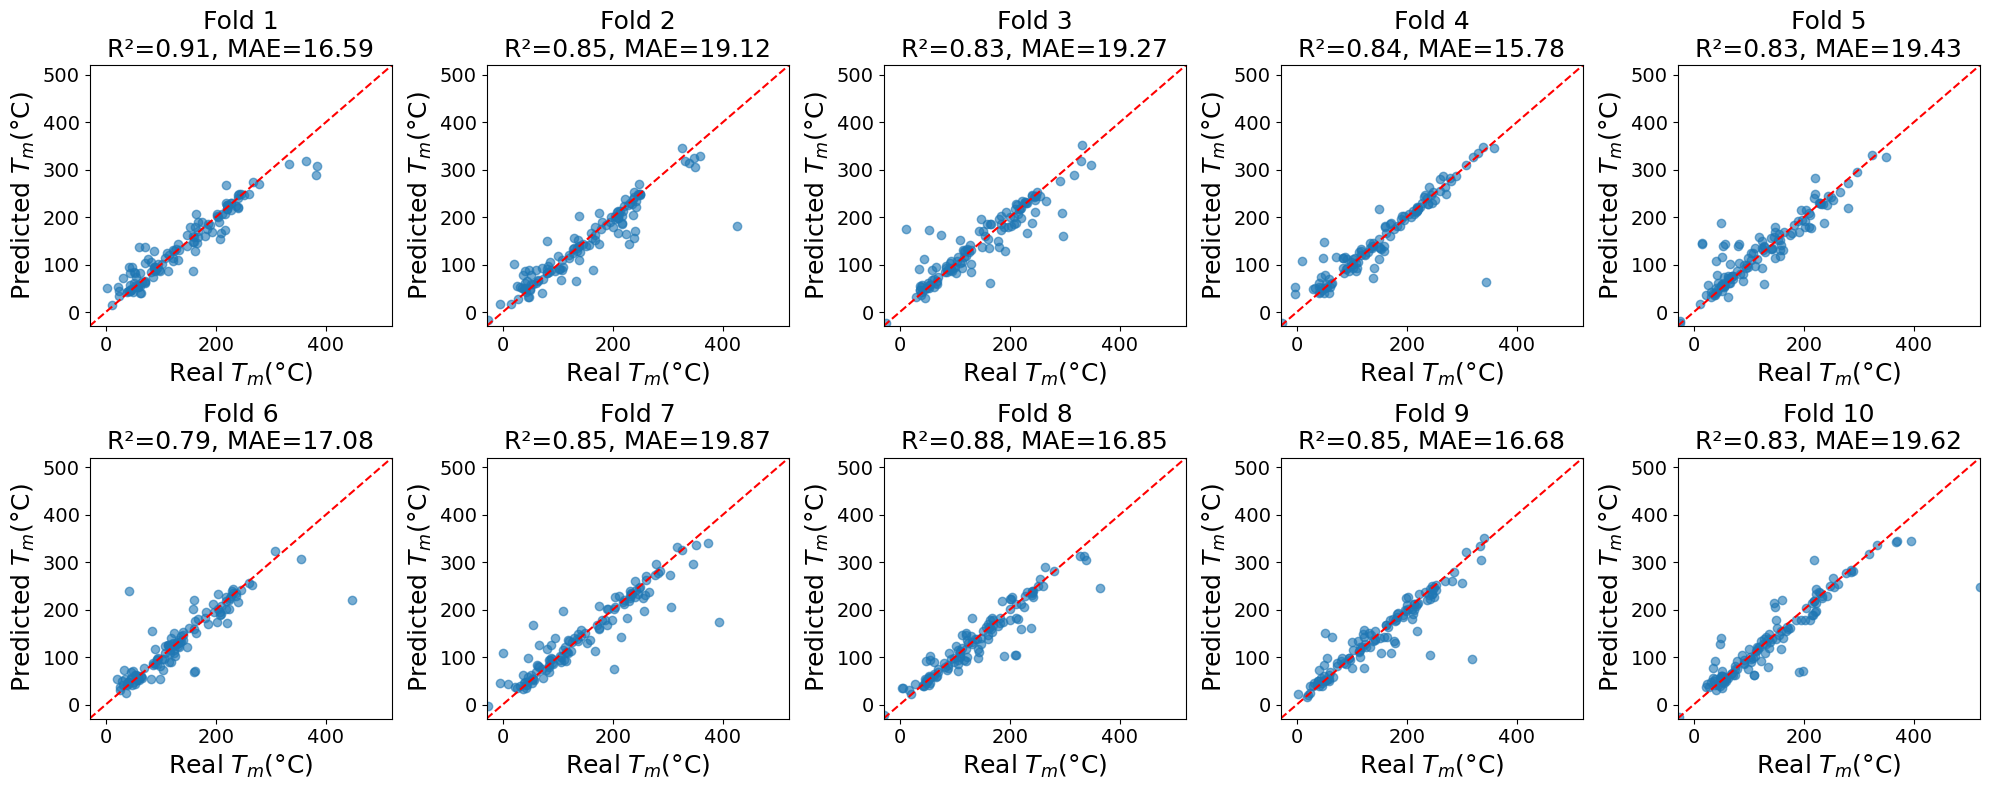

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 获取全局范围
all_true = np.concatenate(test_true_list)
all_pred = np.concatenate(test_pred_list)
min_val = min(all_true.min(), all_pred.min())
max_val = max(all_true.max(), all_pred.max())

for i in range(10):
    ax = axes[i]
    ax.scatter(test_true_list[i], test_pred_list[i], alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val],
            color='red', linestyle='--')
    
    r2 = r2_test_scores[i]
    mae = mae_test_scores[i]
    ax.set_title(f'Fold {i+1}\nR²={r2:.2f}, MAE={mae:.2f}', fontsize=18)
    ax.set_xlabel('Real $T_{m}$(°C)', fontsize=18)
    ax.set_ylabel('Predicted $T_{m}$(°C)', fontsize=18)
    
    # 设置统一坐标范围和刻度字体
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.suptitle('Real vs Predicted $T_{g}$ for Each Fold (Test Set)', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('real_Tm_data_10cv.jpg', dpi=400)


#### 3.2 LLM $T_m$ Prediction performance

In [34]:
#extra_test_set_Tm_gpt = data_Tm[data_Tm['ID'].isin(extra_test_ids)]
extra_test_set_Tm_gpt = data_Tm[data_Tm['ID'].isin(extra_test_ids)]
remaining_data_Tm_gpt = data_gpt_Tm[~data_gpt_Tm['ID'].isin(extra_test_ids)]

# 提取输入和输出 (针对 Tm 列)
X_Tm_gpt = remaining_data_Tm_gpt['morgan_fp_with_freq'].tolist()
y_Tm_gpt = remaining_data_Tm_gpt['Melting temperature'].tolist()

# 将输入转换为合适的格式 (假设每个元素为list型的指纹)
X_extra_test_Tm_gpt = extra_test_set_Tm_gpt['morgan_fp_with_freq'].tolist()
y_extra_test_Tm_gpt = extra_test_set_Tm_gpt['Tm'].tolist()

# 将剩余数据按照 train:valid:test = 8:1:1 划分
X_train_Tm_gpt, X_temp_Tm_gpt, y_train_Tm_gpt, y_temp_Tm_gpt = train_test_split(X_Tm_gpt, y_Tm_gpt, test_size=0.2, random_state=random_seed)
X_valid_Tm_gpt, X_test_Tm_gpt, y_valid_Tm_gpt, y_test_Tm_gpt = train_test_split(X_temp_Tm_gpt, y_temp_Tm_gpt, test_size=0.5, random_state=random_seed)

# 构建随机森林模型
model = RandomForestRegressor(random_state=random_seed)
model.fit(X_train_Tm_gpt, y_train_Tm_gpt)

# 评估模型
y_train_pred_Tm_gpt = model.predict(X_train_Tm_gpt)
y_valid_pred_Tm_gpt = model.predict(X_valid_Tm_gpt)
y_test_pred_Tm_gpt = model.predict(X_test_Tm_gpt)
y_extra_test_pred_Tm_gpt = model.predict(X_extra_test_Tm_gpt)

# 计算 MSE 和 R2
mse_train_Tm_gpt = mean_squared_error(y_train_Tm_gpt, y_train_pred_Tm_gpt)
mse_valid_Tm_gpt = mean_squared_error(y_valid_Tm_gpt, y_valid_pred_Tm_gpt)
mse_test_Tm_gpt = mean_squared_error(y_test_Tm_gpt, y_test_pred_Tm_gpt)
mse_extra_test_Tm_gpt = mean_squared_error(y_extra_test_Tm_gpt, y_extra_test_pred_Tm_gpt)

mae_train_Tm_gpt = mean_absolute_error(y_train_Tm_gpt, y_train_pred_Tm_gpt)
mae_valid_Tm_gpt = mean_absolute_error(y_valid_Tm_gpt, y_valid_pred_Tm_gpt)
mae_test_Tm_gpt = mean_absolute_error(y_test_Tm_gpt, y_test_pred_Tm_gpt)
mae_extra_test_Tm_gpt = mean_absolute_error(y_extra_test_Tm_gpt, y_extra_test_pred_Tm_gpt)

r2_train_Tm_gpt = r2_score(y_train_Tm_gpt, y_train_pred_Tm_gpt)
r2_valid_Tm_gpt = r2_score(y_valid_Tm_gpt, y_valid_pred_Tm_gpt)
r2_test_Tm_gpt = r2_score(y_test_Tm_gpt, y_test_pred_Tm_gpt)
r2_extra_test_Tm_gpt = r2_score(y_extra_test_Tm_gpt, y_extra_test_pred_Tm_gpt)

print(f"Train MSE: {mse_train_Tm_gpt}, MAE:{mae_train_Tm_gpt}, R2: {r2_train_Tm_gpt}")
print(f"Validation MSE: {mse_valid_Tm_gpt}, MAE:{mae_valid_Tm_gpt}, R2: {r2_valid_Tm_gpt}")
print(f"Test MSE: {mse_test_Tm_gpt}, MAE:{mae_test_Tm_gpt}, R2: {r2_test_Tm_gpt}")
print(f"Extra Test MSE: {mse_extra_test_Tm_gpt}, MAE:{mae_extra_test_Tm_gpt}, R2: {r2_extra_test_Tm_gpt}")

Train MSE: 188.54508592818433, MAE:7.99909016336371, R2: 0.9761581023046441
Validation MSE: 533.6694064226153, MAE:15.565985685768302, R2: 0.9228140362245832
Test MSE: 1108.1381936200896, MAE:18.405544171696175, R2: 0.840477891484222
Extra Test MSE: 1159.792724712974, MAE:26.132813245554328, R2: 0.7790332951388849


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_r2 = -np.inf
best_params = None
best_results = {}


param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# 枚举所有参数组合
from itertools import product
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'],
                                   param_grid['min_samples_split'], param_grid['min_samples_leaf']))

X = np.array(X_Tm_gpt)
y = np.array(y_Tm_gpt)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for n_est, max_d, min_split, min_leaf in param_combinations:
    r2_valid_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)
        
        model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        
        r2_valid = r2_score(y_valid, valid_preds)
        r2_valid_scores.append(r2_valid)
    
    mean_r2_valid = np.mean(r2_valid_scores)
    print(f"Params: n_estimators={n_est}, max_depth={max_d}, min_samples_split={min_split}, min_samples_leaf={min_leaf} => mean R2: {mean_r2_valid:.4f}")
    
    if mean_r2_valid > best_r2:
        best_r2 = mean_r2_valid
        best_params = (n_est, max_d, min_split, min_leaf)
        best_results = {
            'mean_r2_valid': mean_r2_valid,
            'params': {
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf
            }
        }

print("\n✅ Best Parameters and R2 Score:")
print(best_results)


In [35]:

X = np.array(X_Tm_gpt)
y = np.array(y_Tm_gpt)

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=46)

# 存储每一折的评估结果
mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]

for train_idx, test_idx in kf.split(X):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    # 在训练集上进行train:valid拆分
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    #model = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42)
    model.fit(X_train, y_train)
    
    # 在验证集和测试集上评估模型
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tm_real)

    mse_train_Tm_gpt = mean_squared_error(y_train, train_preds)
    mse_valid_Tm_gpt = mean_squared_error(y_valid, valid_preds)
    mse_test_Tm_gpt = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tm_gpt=mean_squared_error(y_extra_test_Tm_gpt, extra_test_preds)

    mae_train_Tm_gpt=mean_absolute_error(y_train, train_preds)
    mae_valid_Tm_gpt=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tm_gpt=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tm_gpt=mean_absolute_error(y_extra_test_Tm_gpt, extra_test_preds)

    r2_train_Tm_gpt = r2_score(y_train, train_preds)
    r2_valid_Tm_gpt = r2_score(y_valid, valid_preds)
    r2_test_Tm_gpt = r2_score(y_test, test_preds)
    r2_extra_test_Tm_gpt = r2_score(y_extra_test_Tm_gpt, extra_test_preds)

    mse_train_scores.append(mse_train_Tm_gpt)
    mse_valid_scores.append(mse_valid_Tm_gpt)
    mse_test_scores.append(mse_test_Tm_gpt)
    mse_extra_test_scores.append(mse_extra_test_Tm_gpt)

    mae_train_scores.append(mae_train_Tm_gpt)
    mae_valid_scores.append(mae_valid_Tm_gpt)
    mae_test_scores.append(mae_test_Tm_gpt)
    mae_extra_test_scores.append(mae_extra_test_Tm_gpt)

    r2_train_scores.append(r2_train_Tm_gpt)
    r2_valid_scores.append(r2_valid_Tm_gpt)
    r2_test_scores.append(r2_test_Tm_gpt)
    r2_extra_test_scores.append(r2_extra_test_Tm_gpt)

In [36]:
print(f"Mean Train MSE: {np.mean(mse_train_scores):.4f} ± {np.std(mse_train_scores):.4f}, MAE: {np.mean(mae_train_scores):.4f} ± {np.std(mae_train_scores):.4f}, R2: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Mean Validation MSE: {np.mean(mse_valid_scores):.4f} ± {np.std(mse_valid_scores):.4f}, MAE: {np.mean(mae_valid_scores):.4f} ± {np.std(mae_valid_scores):.4f}, R2: {np.mean(r2_valid_scores):.4f} ± {np.std(r2_valid_scores):.4f}")
print(f"Mean Test MSE: {np.mean(mse_test_scores):.4f} ± {np.std(mse_test_scores):.4f}, MAE: {np.mean(mae_test_scores):.4f} ± {np.std(mae_test_scores):.4f}, R2: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Mean Extra Test MSE: {np.mean(mse_extra_test_scores):.4f} ± {np.std(mse_extra_test_scores):.4f}, MAE: {np.mean(mae_extra_test_scores):.4f} ± {np.std(mae_extra_test_scores):.4f}, R2: {np.mean(r2_extra_test_scores):.4f} ± {np.std(r2_extra_test_scores):.4f}")

Mean Train MSE: 307.4549 ± 29.4353, MAE: 10.2789 ± 0.3696, R2: 0.9603 ± 0.0041
Mean Validation MSE: 1198.6420 ± 438.8512, MAE: 20.1657 ± 2.5003, R2: 0.8416 ± 0.0564
Mean Test MSE: 1133.5422 ± 264.2136, MAE: 20.5492 ± 1.7241, R2: 0.8503 ± 0.0382
Mean Extra Test MSE: 835.1889 ± 79.1770, MAE: 21.8423 ± 1.1006, R2: 0.8409 ± 0.0151


In [37]:

X = np.array(X_Tm_gpt)
y = np.array(y_Tm_gpt)

# 10折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=46)

# 存储每一折的评估结果
mse_train_scores=[]
mse_valid_scores = []
mse_test_scores = []
mse_extra_test_scores=[]

mae_train_scores=[]
mae_valid_scores = []
mae_test_scores = []
mae_extra_test_scores=[]

r2_train_scores=[]
r2_valid_scores = []
r2_test_scores = []
r2_extra_test_scores=[]

# 可视化用列表
test_true_list = []
test_pred_list = []

for train_idx, test_idx in kf.split(X):
    # 训练集和测试集
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #print((len(X_train),len(X_test)))
    
    # 在训练集上进行train:valid拆分
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)  # 8:1:1比例
    #print((len(X_train),len(X_valid),len(X_test)))
    #model = RandomForestRegressor()
    model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42)
    model.fit(X_train, y_train)
    
    # 在验证集和测试集上评估模型
    train_preds=model.predict(X_train)
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)
    extra_test_preds=model.predict(X_extra_test_Tm_real)

    mse_train_Tm_gpt = mean_squared_error(y_train, train_preds)
    mse_valid_Tm_gpt = mean_squared_error(y_valid, valid_preds)
    mse_test_Tm_gpt = mean_squared_error(y_test, test_preds)
    mse_extra_test_Tm_gpt=mean_squared_error(y_extra_test_Tm_gpt, extra_test_preds)

    mae_train_Tm_gpt=mean_absolute_error(y_train, train_preds)
    mae_valid_Tm_gpt=mean_absolute_error(y_valid, valid_preds)
    mae_test_Tm_gpt=mean_absolute_error(y_test, test_preds)
    mae_extra_test_Tm_gpt=mean_absolute_error(y_extra_test_Tm_gpt, extra_test_preds)

    r2_train_Tm_gpt = r2_score(y_train, train_preds)
    r2_valid_Tm_gpt = r2_score(y_valid, valid_preds)
    r2_test_Tm_gpt = r2_score(y_test, test_preds)
    r2_extra_test_Tm_gpt = r2_score(y_extra_test_Tm_gpt, extra_test_preds)

    mse_train_scores.append(mse_train_Tm_gpt)
    mse_valid_scores.append(mse_valid_Tm_gpt)
    mse_test_scores.append(mse_test_Tm_gpt)
    mse_extra_test_scores.append(mse_extra_test_Tm_gpt)

    mae_train_scores.append(mae_train_Tm_gpt)
    mae_valid_scores.append(mae_valid_Tm_gpt)
    mae_test_scores.append(mae_test_Tm_gpt)
    mae_extra_test_scores.append(mae_extra_test_Tm_gpt)

    r2_train_scores.append(r2_train_Tm_gpt)
    r2_valid_scores.append(r2_valid_Tm_gpt)
    r2_test_scores.append(r2_test_Tm_gpt)
    r2_extra_test_scores.append(r2_extra_test_Tm_gpt)

    # 存储真实值与预测值用于绘图
    test_true_list.append(y_test)
    test_pred_list.append(test_preds)

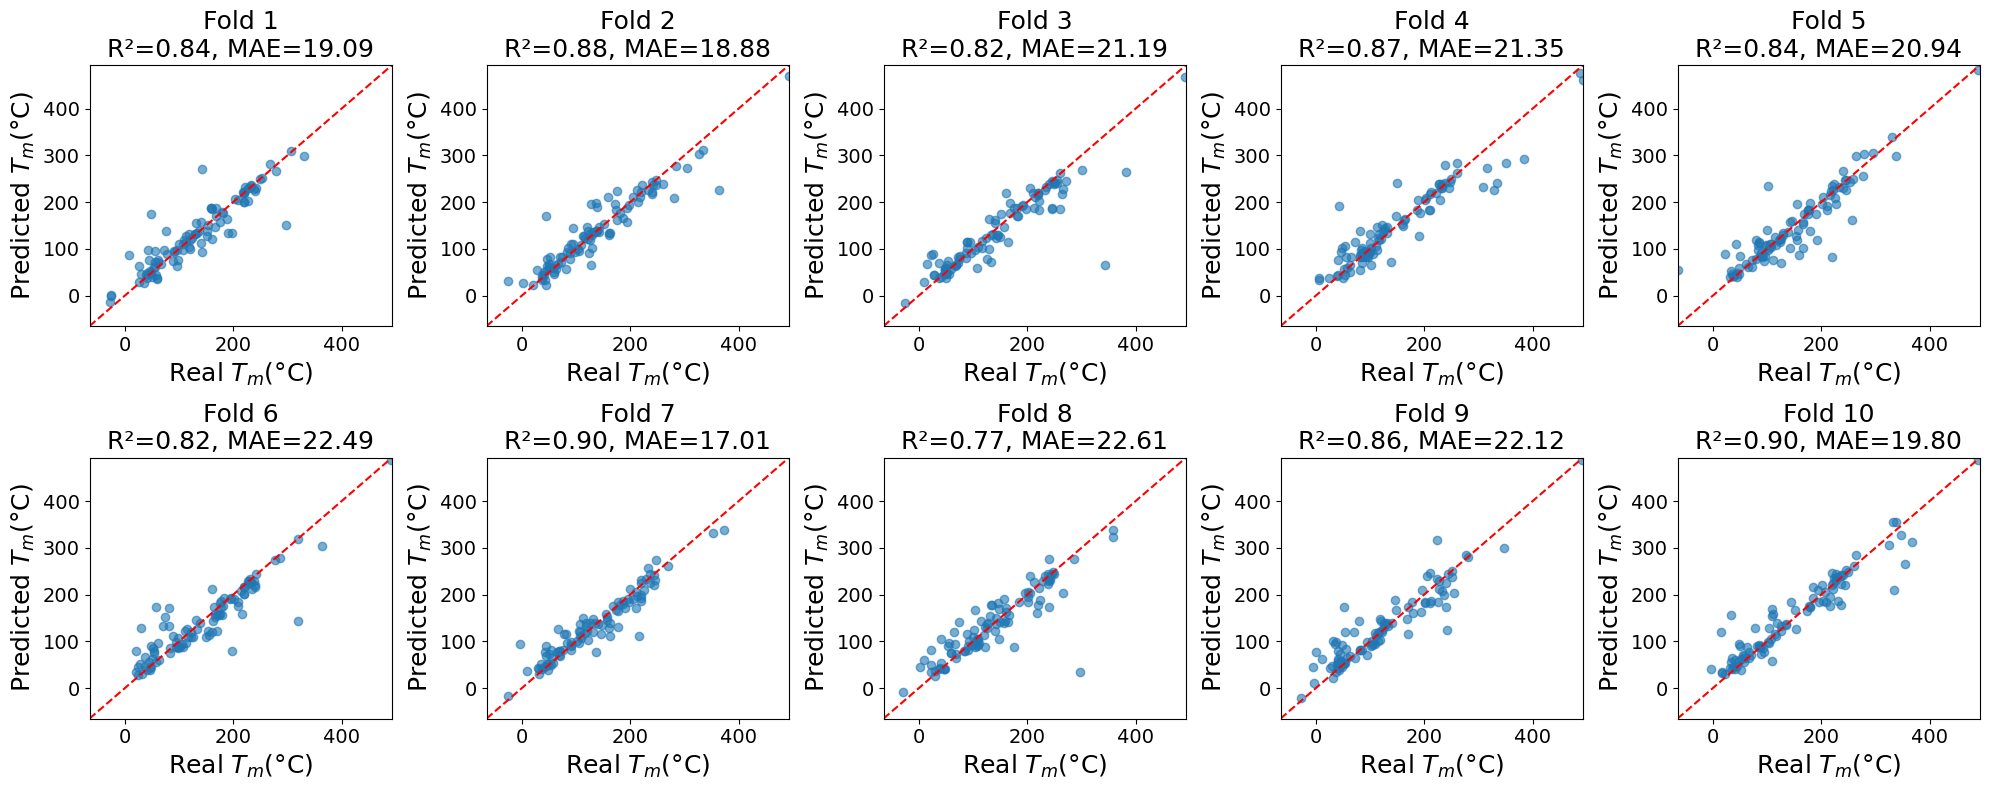

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 获取全局范围
all_true = np.concatenate(test_true_list)
all_pred = np.concatenate(test_pred_list)
min_val = min(all_true.min(), all_pred.min())
max_val = max(all_true.max(), all_pred.max())

for i in range(10):
    ax = axes[i]
    ax.scatter(test_true_list[i], test_pred_list[i], alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val],
            color='red', linestyle='--')
    
    r2 = r2_test_scores[i]
    mae = mae_test_scores[i]
    ax.set_title(f'Fold {i+1}\nR²={r2:.2f}, MAE={mae:.2f}', fontsize=18)
    ax.set_xlabel('Real $T_{m}$(°C)', fontsize=18)
    ax.set_ylabel('Predicted $T_{m}$(°C)', fontsize=18)
    
    # 设置统一坐标范围和刻度字体
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.suptitle('Real vs Predicted $T_{m}$ for Each Fold (Test Set)', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('llm_Tm_data_10cv.jpg', dpi=400)
